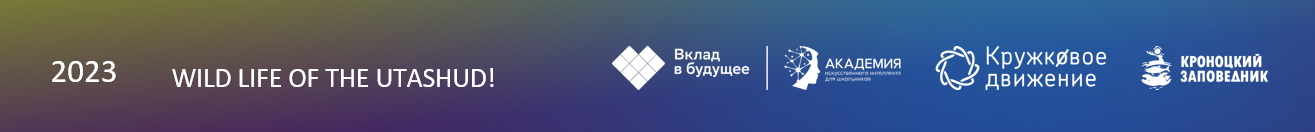

# Дикая жизнь Уташуда! Про чаечек.

# Использование YOLOv8

##Подготовка


###Зависимости

In [ ]:
%pip install ultralytics
import ultralytics
import torch
from PIL import Image
from glob import glob
from sklearn.metrics import mean_squared_error as mse
ultralytics.checks()

from PIL import Image, ImageEnhance
import random as rn

from ultralytics.data.utils import img2label_paths
import numpy as np
import cv2
import os

from tqdm.notebook import tqdm

Ultralytics YOLOv8.0.158 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


###Настройка отображения matplotlib


In [ ]:
%matplotlib notebook
%matplotlib inline

###Логгер

In [ ]:
%pip install clearml
import clearml

%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=SLCY8NPR3W1OSSQG5T5Q
%env CLEARML_API_SECRET_KEY=oyUyI8bAFZtoznoEXCwuhNelIUIFj4Gy91mLepAqG9dnRwlhjR

clearml.browser_login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0
env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=SLCY8NPR3W1OSSQG5T5Q
env: CLEARML_API_SECRET_KEY=oyUyI8bAFZtoznoEXCwuhNelIUIFj4Gy91mLepAqG9dnRwlhjR


###Загрузка датасета

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!rm -r train
!rm -r valid
!rm data.yaml

In [ ]:
!wget https://zaborshicov.ru/hiden/dataset_seagulls.zip -O dataset.zip
!unzip -q dataset.zip
!echo -e "train: /content/train/images\nval: /content/valid/images\nnc: 1\nnames: ['seagull']" > data.yaml

--2023-08-21 06:46:50--  https://zaborshicov.ru/hiden/dataset_seagulls.zip
Resolving zaborshicov.ru (zaborshicov.ru)... 46.8.141.165, 2a0b:6cc0::15
Connecting to zaborshicov.ru (zaborshicov.ru)|46.8.141.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38431264 (37M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  36.65M  14.8MB/s    in 2.5s    

2023-08-21 06:46:54 (14.8 MB/s) - ‘dataset.zip’ saved [38431264/38431264]



###Обработка датасета

Добавим функций из репозитория <a href="https://github.com/Paperspace/DataAugmentationForObjectDetection">Data Augmentation For Object Detection</a>

In [ ]:
!git clone https://github.com/Paperspace/DataAugmentationForObjectDetection
!cp -r DataAugmentationForObjectDetection/data_aug ./
from data_aug.data_aug import *
from data_aug.bbox_util import *

Cloning into 'DataAugmentationForObjectDetection'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 141 (delta 10), reused 8 (delta 8), pack-reused 122
Receiving objects: 100% (141/141), 10.19 MiB | 26.49 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [ ]:
def get_brightness(image):
    mean_img_brightness = np.mean(image, axis=(0, 1))
    return mean_img_brightness

def BrightnessChange(image: np.ndarray):
    mean_image_brightness = get_brightness(image)
    scale = 100 / mean_image_brightness
    new_image = cv2.convertScaleAbs(image, 1, scale)
    return new_image


In [ ]:
img_dir = "train/images"
img_names = os.listdir(img_dir)
brightness_data_before = []
brightness_data_after = []
for img_item in tqdm(img_names):
    img_path = img_dir + "/" + img_item
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    brightness_data_before.append(get_brightness(image))
    image = BrightnessChange(image)
    brightness_data_after.append(get_brightness(image))
    cv2.imwrite(img_path, image)

med_img = list()

for img_path in tqdm(glob("train/images/*.jpg")):
    img = cv2.imread(img_path)
    med_img.append(img)

med_img_np = np.asarray(med_img)
med_img = np.sum(med_img_np, axis=0)
med_img_div = med_img // 500

def med_change(img):
    img = img.astype("int32")
    diff = np.subtract(img,med_img_div)
    diff = np.abs(diff)
    diff = diff.astype("uint8")
    return diff

for img_item in tqdm(img_names):
    img_path = img_dir + "/" + img_item
    image = cv2.imread(img_path)
    image = med_change(image)
    cv2.imwrite(img_path, image)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

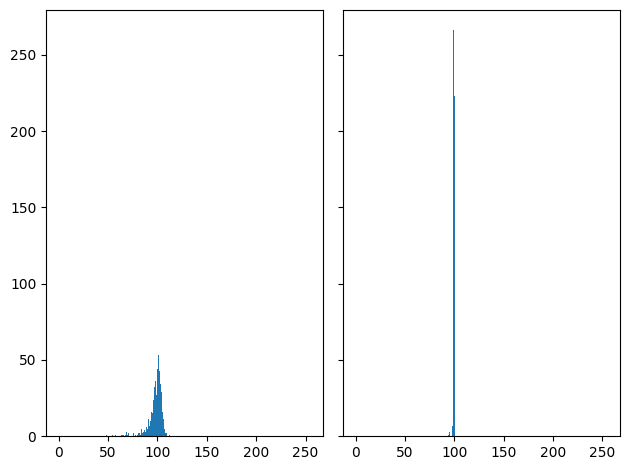

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(brightness_data_before, bins=range(0, 256))
axs[1].hist(brightness_data_after, bins=range(0, 256))

plt.show()

Доступные преобразования:

<li>RandomBrightnessChange</li>
<li>RandomHorizontalFlip</li>
<li>RandomScale</li>
<li>RandomTranslate</li>


In [ ]:
RandomHorizontalFlipFunc = RandomHorizontalFlip(1)
RandomScaleFunc = RandomScale(0.1)
RandomTranslateFunc = RandomTranslate(0.3)

augmentations = {
    #"BRIGHTNESS": BrightnessChange,
    "FLIP" : RandomHorizontalFlipFunc,
    "SCALE" : RandomScaleFunc,
    # "TRANSLATE": RandomTranslateFunc
}

Тестирование яркости

In [ ]:
def load_image(image_path: str):
    label_path = img2label_paths([img_path])[0]
    image = cv2.imread(image_path)
    boxes = conv_label(label_path)
    return image, boxes

def save_image(image_path: str, image: np.ndarray, boxes: np.ndarray):
    cv2.imwrite(image_path, image)
    save_label_to_file(boxes, img2label_paths([image_path])[0] )

Отражение изображений в датасете по горизонтали

In [ ]:
IMG_SIZE = 640

#Функция конвертации лейблов в формат xyxy
def conv_label(label_path):
    file = open(label_path)
    boxlist = []
    for line in file.readlines():
        coord = list(map(float, line.split()))
        x_center, y_center = coord[1], coord[2]
        width, height = coord[3], coord[4]
        coord[1] = x_center - (width / 2)
        coord[2] = y_center + (height / 2)
        coord[3] = x_center + (width / 2)
        coord[4] = y_center - (height / 2)
        coord.append(coord.pop(0))
        boxlist.append(coord)
    file.close()
    boxes = np.asarray(boxlist) * IMG_SIZE
    return boxes

def save_label_to_file(boxes, label_path):
    file = open(label_path, "w")
    for box in boxes:
        coord = box.tolist()
        coord.insert(0, coord.pop(-1))
        width = coord[3] - coord[1]
        height = coord[2] - coord[4]
        xc = coord[3] - (width / 2)
        yc = coord[4] + (height / 2)
        coord[0] = int(coord[0])
        coord[1] = xc / IMG_SIZE
        coord[2] = yc / IMG_SIZE
        coord[3] = width / IMG_SIZE
        coord[4] = height / IMG_SIZE
        file.writelines(" ".join(map(str, coord)))
        file.write("\n")
    file.close()

In [ ]:
#Отражаем изображение и сохраняем в train/images

img_dir = "train/images"
img_names = os.listdir(img_dir)

for img_item in tqdm(img_names):
  img_path = img_dir + "/" + img_item
  img, boxes = load_image(img_path)
  if len(boxes) == 0:
    continue
  for prefix, func in augmentations.items():
    new_img, new_boxes = func(img.copy(), boxes.copy())
    new_img_path = f"train/images/[{prefix}]{img_item}"
    save_image(new_img_path, new_img, new_boxes)


  0%|          | 0/500 [00:00<?, ?it/s]

Статистика по датасету

In [ ]:
pathes = glob('train/labels/*')
nums = []
size_width = []
size_height = []
num_of_images = 0

for pth in pathes:
    with open(pth, 'r') as f:
        nums.append(0)
        num_of_images += 1
        for line in f:
            nums[-1] += 1
            width, height = map(float, line.split(' ')[-2:])
            size_width.append(width*960)
            size_height.append(height*640)

print(f'Среднее количество чаек на фото: {sum(nums)/len(nums):.2f}')
print(f'Средний размер чайки: {sum(size_width)/len(size_width):.2f}x{sum(size_height)/len(size_height):.2f}')
print(f'Количество изображений: {num_of_images}')

Среднее количество чаек на фото: 11.24
Средний размер чайки: 27.74x25.10
Количество изображений: 1436


##Обучение модели


In [ ]:
!yolo train model=yolov8l.pt data=data.yaml epochs=200 imgsz=640 exist_ok=true val=true batch=16
!cp runs/detect/train/weights/best.pt gdrive/MyDrive/Seagul_weights
!cp runs/detect/train/weights/last.pt gdrive/MyDrive/Seagul_weights

100% 83.7M/83.7M [00:00<00:00, 182MB/s]
Ultralytics YOLOv8.0.158 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=data.yaml, epochs=200, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, opt

##Тестирование модели

In [ ]:
model = ultralytics.YOLO("runs/detect/train/weights/best.pt")
#model = ultralytics.YOLO("gdrive/MyDrive/Seagul_weights/last.pt")
model.conf = 0.25 #нижняя планка вероятности для предсказания

distance_k = 1

def predict(img_path: str):
    img = cv2.imread(img_path)
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #img = BrightnessChange(img)
    #cv2.imwrite(img_path, img)
    #img = cv2.imread(img_path)
    #img = med_change(img)
    #cv2.imwrite(img_path, img)
    results = model(img_path, save=True, show_labels=True, conf=0.25, verbose=False)
    result = results[0] # одно изображение
    count = 0
    boxes_set = set()
    for box in result.boxes.xywh:
        x, y, w, h = map(lambda t: t.item(), box[:4])
        if w >= 5 and h >= 5:
            boxes_set.add((x // distance_k, y // distance_k ))
    count = len(boxes_set)
    return count

In [ ]:
preds = []
y = []

for pth in tqdm(glob(r'valid/images/*')):
    count = predict(pth)
    preds.append(count)
    f = open(pth.replace('images', 'labels')[:-3] + 'txt', 'r')
    y.append(len(list(f)))
    f.close()


print(f'RMSE = {mse(y, preds, squared=False)**0.5}')

  0%|          | 0/99 [00:00<?, ?it/s]

Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results save

RMSE = 0.8553821215088305


##Сохранение в файл

In [ ]:
!unzip -q test.zip

In [ ]:
import pandas as pd

paths = []
preds = []
for pth in tqdm(glob('images/*')):
    count = predict(pth)
    preds.append(count)
    paths.append(pth.split('/')[-1])

df = pd.DataFrame(list(zip(paths, preds)), columns=['filename', 'num'])
df.to_csv('count.csv', index=False)
print("=" * 40)
print("Done")

  0%|          | 0/401 [00:00<?, ?it/s]

Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results saved to runs/detect/predict2
Results save

Done


#Эксперименты


In [ ]:
med_img = list()

for img_path in tqdm(glob("train/images/*.jpg")):
    img = cv2.imread(img_path)
    med_img.append(img)

med_img_np = np.asarray(med_img)
med_img = np.sum(med_img_np, axis=0)
med_img_div = med_img // 500

  0%|          | 0/500 [00:00<?, ?it/s]

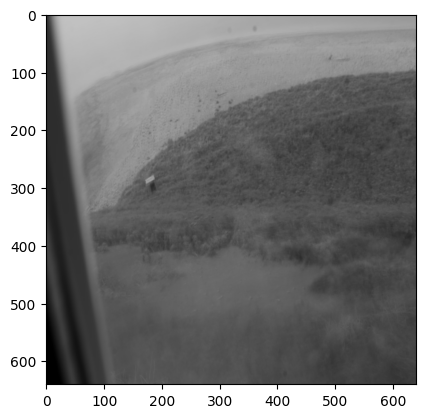

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(med_img_div)
plt.show()

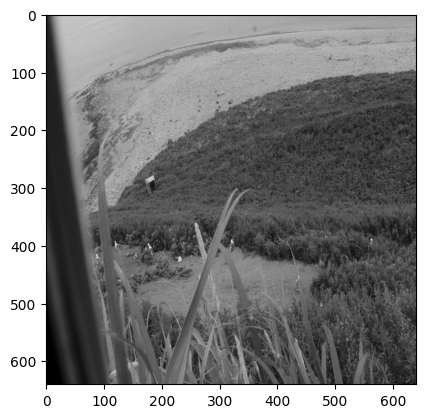

In [ ]:
test_img = cv2.imread("/content/train/images/20200819_142218_01_JPG.rf.723d9e8aa3820ffdf3bded3ffd49aa74.jpg")
plt.imshow(test_img)
plt.show()

0


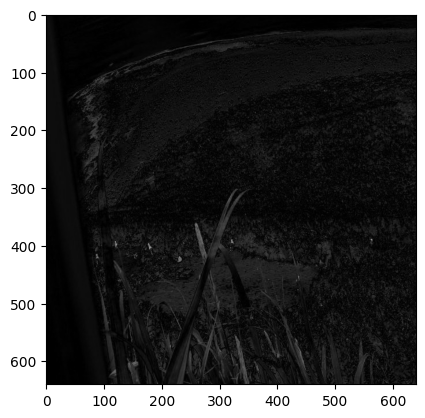

In [ ]:
test_img = test_img.astype("int32")
diff = np.subtract(test_img, med_img_div)
diff = np.abs(diff)

diff = diff.astype("uint8")

print(np.min(diff))
# print(diff)
plt.imshow(diff)
plt.show()